In [1]:
import bldw
import glob
import numpy as np
import blimpy as bl
import matplotlib.pyplot as plt
import setigen
import os
import turbo_seti
%matplotlib inline

# for in-line (non-terminal) turboSETI
# as in Elan Lavie's notebook
import turbo_seti.find_doppler.seti_event as turbo
import turbo_seti.find_event as find
from turbo_seti.find_doppler.find_doppler import FindDoppler
from turbo_seti.find_event.find_event_pipeline import find_event_pipeline
from turbo_seti.find_event.plot_event_pipeline import plot_event_pipeline

numexpr.utils   INFO     Note: NumExpr detected 40 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
numexpr.utils   INFO     NumExpr defaulting to 8 threads.


In [5]:
DATADIR = '/datag/pipeline/AGBT19B_999_121/blc73_blp03/'
lfiles = ['blc73_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.h5',
'blc73_guppi_58832_16530_HIP2792_0058.gpuspec.0000.h5',
'blc73_guppi_58832_16851_MESSIER031_0059.gpuspec.0000.h5',
'blc73_guppi_58832_17168_HIP3077_0060.gpuspec.0000.h5',
'blc73_guppi_58832_17485_MESSIER031_0061.gpuspec.0000.h5',
'blc73_guppi_58832_17801_HIP3223_0062.gpuspec.0000.h5']

In [6]:
fb = bl.Waterfall(DATADIR+lfiles[0])

In [7]:
fb.info()


--- File Info ---
DIMENSION_LABELS : [b'time' b'feed_id' b'frequency']
        az_start :                              0.0
       data_type :                                1
            fch1 :           1688.9648423530161 MHz
            foff :      -2.7939677238464355e-06 MHz
           ibeam :                                1
      machine_id :                               20
          nbeams :                                1
           nbits :                               32
          nchans :                         67108864
            nifs :                                1
     rawdatafile : guppi_58832_16209_MESSIER031_0057.0000.raw
     source_name :                       MESSIER031
         src_dej :                      41:16:03.72
         src_raj :                      0:42:44.448
    telescope_id :                                6
           tsamp :                     18.253611008
   tstart (ISOT) :          2019-12-15T04:30:09.000
    tstart (MJD) :                

In [13]:
print(np.shape(fb.grab_data()[1]))

(16, 67108864)


In [9]:
from astropy import units as u
import setigen as stg

frame = stg.Frame(fchans=1024,
                  tchans=16,
                  df=2.7939677238464355*u.Hz,
                  dt=18.253611008*u.s,
                  fch1=1501.4648451469839*u.MHz,
                  ascending=False)

In [66]:
frame_path = stg.Frame.from_waterfall(DATADIR+lfiles[0])

In [ ]:
# [111, 1743, 362]

In [67]:
signal = frame_path.add_signal(stg.constant_path(f_start=1620.123445*u.MHz,
                                            drift_rate=-2.5*u.Hz/u.s),
                          stg.constant_t_profile(level=frame_path.get_intensity(snr=30)),
                          stg.sinc2_f_profile(width=40*u.Hz),
                          stg.constant_bp_profile(level=1))

signal = frame_path.add_signal(stg.constant_path(f_start=1548.435456*u.MHz,
                                            drift_rate=2*u.Hz/u.s),
                          stg.constant_t_profile(level=frame_path.get_intensity(snr=20)),
                          stg.sinc2_f_profile(width=60*u.Hz),
                          stg.constant_bp_profile(level=1))

signal = frame_path.add_signal(stg.constant_path(f_start=1598.324118*u.MHz,
                                            drift_rate=1*u.Hz/u.s),
                          stg.constant_t_profile(level=frame_path.get_intensity(snr=100)),
                          stg.sinc2_f_profile(width=10*u.Hz),
                          stg.constant_bp_profile(level=1))

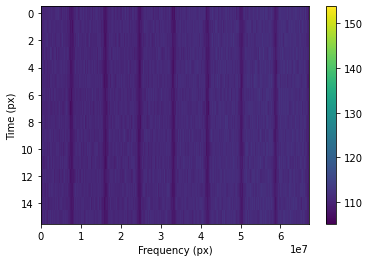

In [23]:
frame_path.plot("px")

In [68]:
wf = frame_path.get_waterfall()

In [27]:
frame_path.get_frequency(200)*1e-6

1501.4654039405286

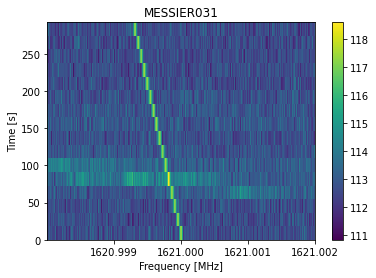

In [65]:
bw = 0.004
cf = frame_path.get_frequency(10000)*1e-6
cf = 1621
wf.plot_waterfall(f_start = cf-bw/2, f_stop = cf+bw/2, logged=True)

In [69]:
frame_path.save_fil(filename='/datax/scratch/benjb/m31_observation_with_setigen.fil')

blimpy.waterfall INFO     __write_to_fil_light: Writing the spectra matrix for /datax/scratch/benjb/m31_observation_with_setigen.fil in one go.
blimpy.waterfall INFO     Conversion time: 2.53sec


In [70]:
fb = bl.Waterfall('/datax/scratch/benjb/m31_observation_with_setigen.fil')

In [37]:
# Uncomment for copying files into scratch directory — hopefully shouldn't be necessary for en-masse runs?

for file in lfiles:
    console = f'cp {DATADIR}{file} /datax/scratch/benjb/'
    os.system(console)

In [9]:
# remove DC spikes in absence of turboSETI blank_DC option
# not needed for time-resolution spectra

data_loc = '/datax/scratch/benjb/C23_L_M31_injections'
files = glob.glob(data_loc + '/*.h5')

for file in files:
    fb = bl.Waterfall(file)
    fb.blank_dc(64)
    fb.write_to_hdf5(f'{data_loc}/bDC_{file[42:]}')

blimpy.waterfall INFO     __write_to_hdf5_light: Writing the spectra matrix for /datax/scratch/benjb/C23_L_M31_injections/bDC_blc74_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.h5 without blobbing.
blimpy.waterfall INFO     Conversion time: 4.91sec
blimpy.waterfall INFO     __write_to_hdf5_light: Writing the spectra matrix for /datax/scratch/benjb/C23_L_M31_injections/bDC_blc74_guppi_58832_16851_MESSIER031_0059.gpuspec.0000.h5 without blobbing.
blimpy.waterfall INFO     Conversion time: 4.92sec
blimpy.waterfall INFO     __write_to_hdf5_light: Writing the spectra matrix for /datax/scratch/benjb/C23_L_M31_injections/bDC_blc74_guppi_58832_17485_MESSIER031_0061.gpuspec.0000.h5 without blobbing.
blimpy.waterfall INFO     Conversion time: 4.88sec



--- File Info ---
DIMENSION_LABELS : [b'time' b'feed_id' b'frequency']
        az_start :                              0.0
       data_type :                                1
            fch1 :           1501.4648423530161 MHz
            foff :      -2.7939677238464355e-06 MHz
           ibeam :                                1
      machine_id :                               20
          nbeams :                                1
           nbits :                               32
          nchans :                         67108864
            nifs :                                1
     rawdatafile : guppi_58832_16209_MESSIER031_0057.0000.raw
     source_name :                       MESSIER031
         src_dej :                      41:16:03.72
         src_raj :                      0:42:44.448
    telescope_id :                                6
           tsamp :                     18.253611008
   tstart (ISOT) :          2019-12-15T04:30:09.000
    tstart (MJD) :                

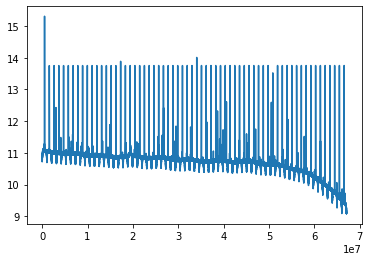

In [2]:
fb = bl.Waterfall('/datax/scratch/benjb/C23_L_M31_injections/blc74_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.h5')
fb.info()
spec = np.average(np.squeeze(fb.data), axis=0)
plt.plot(np.log10(spec))
plt.show()

In [2]:
print('Beginning turboSETI search (FindDoppler version) ...')

data_loc = '/datax/scratch/benjb/C23_L_M81_injections'
files = glob.glob(data_loc + '/*.h5')

for file in files:
    doppler = FindDoppler(file,
                      max_drift = 4,
                      snr = 10,       
                      out_dir = data_loc,
                      n_coarse_chan = 64,
                      gpu_backend = True,
                      blank_dc = True
                     )
    doppler.search()

print('Done!')


Beginning turboSETI search (FindDoppler version) ...

turbo_seti version 2.3.2
blimpy version 2.1.4
h5py version 2.10.0
hdf5plugin version 2.1.2
HDF5 library version 1.10.5


data_handler    INFO     From user, n_coarse_chan=512
HDF5 header info: {'DIMENSION_LABELS': array([b'time', b'feed_id', b'frequency'], dtype=object), 'az_start': 0.0, 'data_type': 1, 'fch1': 2251.46484375, 'foff': -2.7939677238464355e-06, 'machine_id': 20, 'nbits': 32, 'nchans': 536870912, 'nifs': 1, 'source_name': 'MESSIER081', 'src_dej': <Angle 69.0655 deg>, 'src_raj': <Angle 9.92588667 hourangle>, 'telescope_id': 6, 'tsamp': 18.253611007999982, 'tstart': 58885.73664351852, 'za_start': 0.0}

Starting ET search with parameters: datafile=/datax/scratch/benjb/C23_L_M81_injections/spliced_blc4041424344454647_guppi_58885_63646_MESSIER081_0057.rawspec.0000.h5, max_drift=4, min_drift=1e-05, snr=10, out_dir=/datax/scratch/benjb/C23_L_M81_injections, coarse_chans=None, flagging=False, n_coarse_chan=512, kernels=None, gp

In [5]:
import pandas as pd
dat = glob.glob('/datax/scratch/benjb/C23_L_M81_injections/*.dat')[0]
df = pd.read_table(dat, sep='\s+', names=['Top_Hit_#','Drift_Rate','SNR','Uncorrected_Frequency','Corrected_Frequency',
                                            'Index', 'freq_start', 'freq_end', 'SEFD', 'SEFD_freq', 'Coarse_Channel_Number', 
                                            'Full_number_of_hits'], skiprows=9)
table_freqs = df['Uncorrected_Frequency'].values[np.where(
    (df['Uncorrected_Frequency'].values > 1100) & (df['Uncorrected_Frequency'].values < 1200) |
    (df['Uncorrected_Frequency'].values > 1340) & (df['Uncorrected_Frequency'].values < 1900)
)]
table_drifts = df['Drift_Rate'].values[np.where(
    (df['Uncorrected_Frequency'].values > 1100) & (df['Uncorrected_Frequency'].values < 1200) |
    (df['Uncorrected_Frequency'].values > 1340) & (df['Uncorrected_Frequency'].values < 1900)
)]
table_snrs = df['SNR'].values[np.where(
    (df['Uncorrected_Frequency'].values > 1100) & (df['Uncorrected_Frequency'].values < 1200) |
    (df['Uncorrected_Frequency'].values > 1340) & (df['Uncorrected_Frequency'].values < 1900)
)]

In [8]:
arr = np.load('/datax/scratch/benjb/C23_L_M81_injections/injections_freq_DR_snr_widths_MESSIER081.npy', allow_pickle=True)
freqs = arr[0]
drifts = arr[1]
snrs = arr[2]
widths = arr[3]
print(arr.shape)

(4, 100)


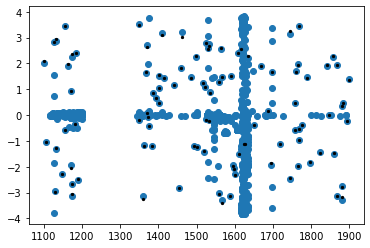

In [12]:
plt.scatter(table_freqs, table_drifts)
plt.scatter(freqs, drifts, s=5, c='k')
#plt.yscale('log')
plt.show()

In [17]:
counter = 0
for freq in freqs:
    diff_vec = table_freqs - freq
    if 0 in np.round(diff_vec, 3):
        counter += 1
print(counter)

idxs_vec = []
for freq in freqs:
    diff_vec = np.abs(table_freqs - freq)
    if 0 in np.round(diff_vec, 3):
        idx = np.argmin(diff_vec)
        idxs_vec.append(idx)

100


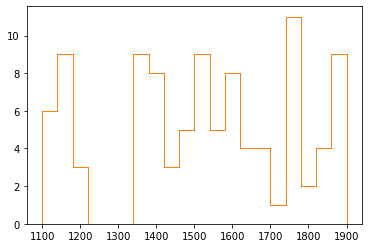

In [28]:
plt.hist(table_freqs[idxs_vec], bins=20, range=(1100, 1900), histtype='step')
plt.hist(freqs, bins=20, range=(1100, 1900), histtype='step')
plt.show()

In [29]:
np.save('/datax/scratch/benjb/C23_L_M81_injections/idxs_of_injections_in_dat.npy', idxs_vec)

In [13]:
import pandas as pd
dats = np.sort(glob.glob('/datax/scratch/benjb/C23_L_M31_injections/M31_dats_no_injections/blc7*.dat'))
freqs = []
drifts = []
snrs = []
for dat in dats:
    df = pd.read_table(dat, sep='\s+', names=['Top_Hit_#','Drift_Rate','SNR','Uncorrected_Frequency','Corrected_Frequency',
                                            'Index', 'freq_start', 'freq_end', 'SEFD', 'SEFD_freq', 'Coarse_Channel_Number', 
                                            'Full_number_of_hits'], skiprows=9)
    table_freqs = df['Uncorrected_Frequency'].values
    table_drifts = df['Drift_Rate'].values
    table_snrs = df['SNR'].values
    freqs.append(table_freqs)
    drifts.append(table_drifts)
    snrs.append(table_snrs)
freqs = np.concatenate(freqs)
drifts = np.concatenate(drifts)
snrs = np.concatenate(snrs)

In [14]:
dats2 = ['/home/obs/turboseti/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_16209_MESSIER031_0057.gpuspec.0000/blc73_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.dat',
'/home/obs/turboseti/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_16530_HIP2792_0058.gpuspec.0000/blc73_guppi_58832_16530_HIP2792_0058.gpuspec.0000.dat',
'/home/obs/turboseti/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_16851_MESSIER031_0059.gpuspec.0000/blc73_guppi_58832_16851_MESSIER031_0059.gpuspec.0000.dat',
'/home/obs/turboseti/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_17168_HIP3077_0060.gpuspec.0000/blc73_guppi_58832_17168_HIP3077_0060.gpuspec.0000.dat',
'/home/obs/turboseti/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_17485_MESSIER031_0061.gpuspec.0000/blc73_guppi_58832_17485_MESSIER031_0061.gpuspec.0000.dat',
'/home/obs/turboseti/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_17801_HIP3223_0062.gpuspec.0000/blc73_guppi_58832_17801_HIP3223_0062.gpuspec.0000.dat',
'/home/obs/turboseti/AGBT19B_999_121/blc75_blp05/blc75_guppi_58832_16209_MESSIER031_0057.gpuspec.0000/blc75_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.dat',
'/home/obs/turboseti/AGBT19B_999_121/blc75_blp05/blc75_guppi_58832_16530_HIP2792_0058.gpuspec.0000/blc75_guppi_58832_16530_HIP2792_0058.gpuspec.0000.dat',
'/home/obs/turboseti/AGBT19B_999_121/blc75_blp05/blc75_guppi_58832_16851_MESSIER031_0059.gpuspec.0000/blc75_guppi_58832_16851_MESSIER031_0059.gpuspec.0000.dat',
'/home/obs/turboseti/AGBT19B_999_121/blc75_blp05/blc75_guppi_58832_17168_HIP3077_0060.gpuspec.0000/blc75_guppi_58832_17168_HIP3077_0060.gpuspec.0000.dat',
'/home/obs/turboseti/AGBT19B_999_121/blc75_blp05/blc75_guppi_58832_17485_MESSIER031_0061.gpuspec.0000/blc75_guppi_58832_17485_MESSIER031_0061.gpuspec.0000.dat',
'/home/obs/turboseti/AGBT19B_999_121/blc75_blp05/blc75_guppi_58832_17801_HIP3223_0062.gpuspec.0000/blc75_guppi_58832_17801_HIP3223_0062.gpuspec.0000.dat']

freqs2 = []
drifts2 = []
snrs2 = []
for dat in dats2:
    df = pd.read_table(dat, sep='\s+', names=['Top_Hit_#','Drift_Rate','SNR','Uncorrected_Frequency','Corrected_Frequency',
                                            'Index', 'freq_start', 'freq_end', 'SEFD', 'SEFD_freq', 'Coarse_Channel_Number', 
                                            'Full_number_of_hits'], skiprows=9)
    table_freqs = df['Uncorrected_Frequency'].values
    table_drifts = df['Drift_Rate'].values
    table_snrs = df['SNR'].values
    freqs2.append(table_freqs)
    drifts2.append(table_drifts)
    snrs2.append(table_snrs)
freqs2 = np.concatenate(freqs2)
drifts2 = np.concatenate(drifts2)
snrs2 = np.concatenate(snrs2)

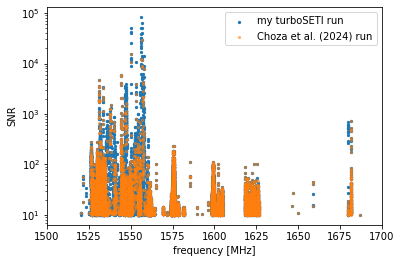

In [32]:
plt.scatter(freqs, snrs, s=5, alpha=1, label='my turboSETI run')
plt.scatter(freqs2, snrs2, s=5, alpha=0.5, label='Choza et al. (2024) run')
plt.yscale('log')
plt.xlabel('frequency [MHz]')
plt.ylabel('SNR')
plt.legend(loc='upper right')
plt.xlim(1500,1700)
plt.show()

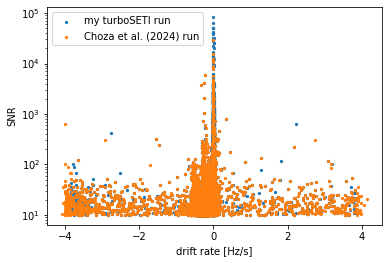

In [30]:
plt.scatter(drifts, snrs, s=5, alpha=1, label='my turboSETI run')
plt.scatter(drifts2, snrs2, s=5, alpha=1, label='Choza et al. (2024) run')
plt.yscale('log')
plt.xlabel('drift rate [Hz/s]')
plt.ylabel('SNR')
plt.legend(loc='upper left')
plt.show()

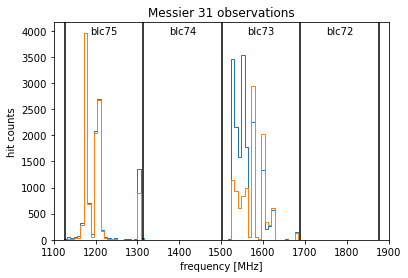

In [9]:
plt.hist(freqs, bins=100, histtype='step', range=(1100, 1900))
plt.hist(freqs2, bins=100, histtype='step', range=(1100, 1900))
plt.axvline(1126.4648451469839, color='k')
plt.axvline(1313.9648451469839, color='k')
plt.axvline(1501.4648451469839, color='k')
plt.axvline(1688.9648451469839, color='k')
plt.axvline(1876.4648423530161, color='k')
plt.text(1313.9648451469839-187.5/2, 4000, 'blc75', horizontalalignment='center', verticalalignment='center')
plt.text(1501.4648451469839-187.5/2, 4000, 'blc74', horizontalalignment='center', verticalalignment='center')
plt.text(1688.9648451469839-187.5/2, 4000, 'blc73', horizontalalignment='center', verticalalignment='center')
plt.text(1876.4648423530161-187.5/2, 4000, 'blc72', horizontalalignment='center', verticalalignment='center')
plt.ylabel('hit counts')
plt.xlabel('frequency [MHz]')
plt.title('Messier 31 observations')
plt.xlim(1100, 1900)
#plt.yscale('log')
plt.show()

In [33]:
import pandas as pd
dats = np.sort(glob.glob('/datax/scratch/benjb/C23_L_M31_injections/M31_dats_no_injections/blc0*.dat'))
freqs = []
drifts = []
snrs = []
for dat in dats:
    df = pd.read_table(dat, sep='\s+', names=['Top_Hit_#','Drift_Rate','SNR','Uncorrected_Frequency','Corrected_Frequency',
                                            'Index', 'freq_start', 'freq_end', 'SEFD', 'SEFD_freq', 'Coarse_Channel_Number', 
                                            'Full_number_of_hits'], skiprows=9)
    table_freqs = df['Uncorrected_Frequency'].values
    table_drifts = df['Drift_Rate'].values
    table_snrs = df['SNR'].values
    freqs.append(table_freqs)
    drifts.append(table_drifts)
    snrs.append(table_snrs)
freqs = np.concatenate(freqs)
drifts = np.concatenate(drifts)
snrs = np.concatenate(snrs)

In [34]:
dats2 = ['/home/obs/turboseti/AGBT22B_999_19/blc03_blp03/blc03_guppi_59884_32541_MESSIER033_0010.rawspec.0000/blc03_guppi_59884_32541_MESSIER033_0010.rawspec.0000.dat',
'/home/obs/turboseti/AGBT22B_999_19/blc03_blp03/blc03_guppi_59884_32854_HIP7229_0011.rawspec.0000/blc03_guppi_59884_32854_HIP7229_0011.rawspec.0000.dat',
'/home/obs/turboseti/AGBT22B_999_19/blc03_blp03/blc03_guppi_59884_33167_MESSIER033_0012.rawspec.0000/blc03_guppi_59884_33167_MESSIER033_0012.rawspec.0000.dat',
'/home/obs/turboseti/AGBT22B_999_19/blc03_blp03/blc03_guppi_59884_33484_HIP7612_0013.rawspec.0000/blc03_guppi_59884_33484_HIP7612_0013.rawspec.0000.dat',
'/home/obs/turboseti/AGBT22B_999_19/blc03_blp03/blc03_guppi_59884_33801_MESSIER033_0014.rawspec.0000/blc03_guppi_59884_33801_MESSIER033_0014.rawspec.0000.dat',
'/home/obs/turboseti/AGBT22B_999_19/blc03_blp03/blc03_guppi_59884_34123_HIP7960_0015.rawspec.0000/blc03_guppi_59884_34123_HIP7960_0015.rawspec.0000.dat',
'/home/obs/turboseti/AGBT22B_999_19/blc05_blp05/blc05_guppi_59884_32541_MESSIER033_0010.rawspec.0000/blc05_guppi_59884_32541_MESSIER033_0010.rawspec.0000.dat',
'/home/obs/turboseti/AGBT22B_999_19/blc05_blp05/blc05_guppi_59884_32854_HIP7229_0011.rawspec.0000/blc05_guppi_59884_32854_HIP7229_0011.rawspec.0000.dat',
'/home/obs/turboseti/AGBT22B_999_19/blc05_blp05/blc05_guppi_59884_33167_MESSIER033_0012.rawspec.0000/blc05_guppi_59884_33167_MESSIER033_0012.rawspec.0000.dat',
'/home/obs/turboseti/AGBT22B_999_19/blc05_blp05/blc05_guppi_59884_33484_HIP7612_0013.rawspec.0000/blc05_guppi_59884_33484_HIP7612_0013.rawspec.0000.dat',
'/home/obs/turboseti/AGBT22B_999_19/blc05_blp05/blc05_guppi_59884_33801_MESSIER033_0014.rawspec.0000/blc05_guppi_59884_33801_MESSIER033_0014.rawspec.0000.dat',
'/home/obs/turboseti/AGBT22B_999_19/blc05_blp05/blc05_guppi_59884_34123_HIP7960_0015.rawspec.0000/blc05_guppi_59884_34123_HIP7960_0015.rawspec.0000.dat']

freqs2 = []
drifts2 = []
snrs2 = []
for dat in dats2:
    df = pd.read_table(dat, sep='\s+', names=['Top_Hit_#','Drift_Rate','SNR','Uncorrected_Frequency','Corrected_Frequency',
                                            'Index', 'freq_start', 'freq_end', 'SEFD', 'SEFD_freq', 'Coarse_Channel_Number', 
                                            'Full_number_of_hits'], skiprows=9)
    table_freqs = df['Uncorrected_Frequency'].values
    table_drifts = df['Drift_Rate'].values
    table_snrs = df['SNR'].values
    freqs2.append(table_freqs)
    drifts2.append(table_drifts)
    snrs2.append(table_snrs)
freqs2 = np.concatenate(freqs2)
drifts2 = np.concatenate(drifts2)
snrs2 = np.concatenate(snrs2)

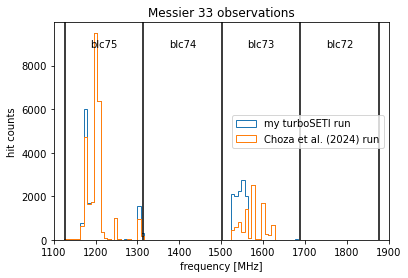

In [37]:
plt.hist(freqs, bins=100, histtype='step', range=(1100, 1900), label='my turboSETI run')
plt.hist(freqs2, bins=100, histtype='step', range=(1100, 1900), label='Choza et al. (2024) run')
plt.axvline(1126.4648451469839, color='k')
plt.axvline(1313.9648451469839, color='k')
plt.axvline(1501.4648451469839, color='k')
plt.axvline(1688.9648451469839, color='k')
plt.axvline(1876.4648423530161, color='k')
plt.text(1313.9648451469839-187.5/2, 9000, 'blc75', horizontalalignment='center', verticalalignment='center')
plt.text(1501.4648451469839-187.5/2, 9000, 'blc74', horizontalalignment='center', verticalalignment='center')
plt.text(1688.9648451469839-187.5/2, 9000, 'blc73', horizontalalignment='center', verticalalignment='center')
plt.text(1876.4648423530161-187.5/2, 9000, 'blc72', horizontalalignment='center', verticalalignment='center')
plt.ylabel('hit counts')
plt.xlabel('frequency [MHz]')
plt.title('Messier 33 observations')
plt.xlim(1100, 1900)
plt.legend(loc='center right')
#plt.yscale('log')
plt.show()

In [5]:
print('Beginning turboSETI search (command line version) ...')

for i in range(len(lfiles)):
    # Execute turboSETI in the terminal
    console = 'turboSETI ' + DATADIR + lfiles[i] + ' -M 4 -s 10 -o' + '/datax/scratch/benjb/'
    os.system(console)

print('Done!')

Beginning turboSETI search ...
Done!


In [5]:
print('Beginning plotSETI algorithm ...')

console = "plotSETI -f 3 -o " + DATADIR + " " + DATADIR
print(console)
os.system(console)

print('Done!')

Beginning plotSETI algorithm ...
plotSETI -f 3 -o /datax/scratch/benjb/m31_data/ /datax/scratch/benjb/m31_data/
Done!


In [ ]:
DATADIR = '/datag/pipeline/AGBT19B_999_121/blc75_blp05/'
lfiles = ['blc75_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.h5',
'blc75_guppi_58832_16530_HIP2792_0058.gpuspec.0000.h5',
'blc75_guppi_58832_16851_MESSIER031_0059.gpuspec.0000.h5',
'blc75_guppi_58832_17168_HIP3077_0060.gpuspec.0000.h5',
'blc75_guppi_58832_17485_MESSIER031_0061.gpuspec.0000.h5',
'blc75_guppi_58832_17801_HIP3223_0062.gpuspec.0000.h5']

In [39]:
# Create a simple .lst file of the .h5 files in the data directory
#h5_list = ['/datax/scratch/benjb/C23_L_M31_injections/blc73_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.h5',
#           '/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_16530_HIP2792_0058.gpuspec.0000.h5',
#           '/datax/scratch/benjb/C23_L_M31_injections/blc73_guppi_58832_16851_MESSIER031_0059.gpuspec.0000.h5',
#           '/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_17168_HIP3077_0060.gpuspec.0000.h5',
#           '/datax/scratch/benjb/C23_L_M31_injections/blc73_guppi_58832_17485_MESSIER031_0061.gpuspec.0000.h5',
#           '/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_17801_HIP3223_0062.gpuspec.0000.h5']
h5_list = [
    '/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.h5',
'/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_16530_HIP2792_0058.gpuspec.0000.h5',
'/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_16851_MESSIER031_0059.gpuspec.0000.h5',
'/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_17168_HIP3077_0060.gpuspec.0000.h5',
'/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_17485_MESSIER031_0061.gpuspec.0000.h5',
'/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_17801_HIP3223_0062.gpuspec.0000.h5'
]
#h5_list = [DATADIR + file for file in lfiles]

# This writes the .h5 files into a .lst, as required by the find_event_pipeline:
h5_list_path = os.path.join(data_loc,'blc73_M31_h5_files_no_injections.lst')
with open(h5_list_path, 'w') as f:
    for h5_path in h5_list:
        f.write(h5_path + '\n')

# You don't have to print, but it's a good way to check that your list is in the correct order:
with open(h5_list_path, 'r') as f:
    print(f.read())

/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.h5
/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_16530_HIP2792_0058.gpuspec.0000.h5
/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_16851_MESSIER031_0059.gpuspec.0000.h5
/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_17168_HIP3077_0060.gpuspec.0000.h5
/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_17485_MESSIER031_0061.gpuspec.0000.h5
/datag/pipeline/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_17801_HIP3223_0062.gpuspec.0000.h5



In [37]:
# Create a simple .lst file of the .dat files in the data directory
#dat_list = [
#    '/datax/scratch/benjb/C23_L_M31_injections/blc73_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.dat',
#'/home/obs/turboseti/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_16530_HIP2792_0058.gpuspec.0000/blc73_guppi_58832_16530_HIP2792_0058.gpuspec.0000.dat',
#'/datax/scratch/benjb/C23_L_M31_injections/blc73_guppi_58832_16851_MESSIER031_0059.gpuspec.0000.dat',
#'/home/obs/turboseti/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_17168_HIP3077_0060.gpuspec.0000/blc73_guppi_58832_17168_HIP3077_0060.gpuspec.0000.dat',
#'/datax/scratch/benjb/C23_L_M31_injections/blc73_guppi_58832_17485_MESSIER031_0061.gpuspec.0000.dat',
#'/home/obs/turboseti/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_17801_HIP3223_0062.gpuspec.0000/blc73_guppi_58832_17801_HIP3223_0062.gpuspec.0000.dat'
#]
dat_list = [
    '/home/obs/turboseti/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_16209_MESSIER031_0057.gpuspec.0000/blc73_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.dat',
'/home/obs/turboseti/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_16530_HIP2792_0058.gpuspec.0000/blc73_guppi_58832_16530_HIP2792_0058.gpuspec.0000.dat',
'/home/obs/turboseti/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_16851_MESSIER031_0059.gpuspec.0000/blc73_guppi_58832_16851_MESSIER031_0059.gpuspec.0000.dat',
'/home/obs/turboseti/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_17168_HIP3077_0060.gpuspec.0000/blc73_guppi_58832_17168_HIP3077_0060.gpuspec.0000.dat',
'/home/obs/turboseti/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_17485_MESSIER031_0061.gpuspec.0000/blc73_guppi_58832_17485_MESSIER031_0061.gpuspec.0000.dat',
'/home/obs/turboseti/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_17801_HIP3223_0062.gpuspec.0000/blc73_guppi_58832_17801_HIP3223_0062.gpuspec.0000.dat'
]
#dat_list = [data_loc + file[:-2] + 'dat' for file in lfiles]
    
# This writes the .dat files into a .lst, as required by the find_event_pipeline:
dat_list_path = os.path.join(data_loc, 'blc73_M31_dat_files_no_injections.lst')
with open(dat_list_path, 'w') as f:
    for dat_path in dat_list:
        f.write(dat_path + '\n')

# You don't have to print, but it's a good way to check that your list is in the correct order:
with open(dat_list_path, 'r') as f:
    print(f.read())

/home/obs/turboseti/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_16209_MESSIER031_0057.gpuspec.0000/blc73_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.dat
/home/obs/turboseti/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_16530_HIP2792_0058.gpuspec.0000/blc73_guppi_58832_16530_HIP2792_0058.gpuspec.0000.dat
/home/obs/turboseti/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_16851_MESSIER031_0059.gpuspec.0000/blc73_guppi_58832_16851_MESSIER031_0059.gpuspec.0000.dat
/home/obs/turboseti/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_17168_HIP3077_0060.gpuspec.0000/blc73_guppi_58832_17168_HIP3077_0060.gpuspec.0000.dat
/home/obs/turboseti/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_17485_MESSIER031_0061.gpuspec.0000/blc73_guppi_58832_17485_MESSIER031_0061.gpuspec.0000.dat
/home/obs/turboseti/AGBT19B_999_121/blc73_blp03/blc73_guppi_58832_17801_HIP3223_0062.gpuspec.0000/blc73_guppi_58832_17801_HIP3223_0062.gpuspec.0000.dat



In [40]:
csvf_path = os.path.join(data_loc, 'blc73_M31_found_event_table_3_no_injections.csv')
find_event_pipeline(dat_list_path, 
                    h5_list_path,
                    SNR_cut=10,
                    check_zero_drift=True,
                    filter_threshold = 3, 
                    number_in_cadence = len(dat_list), 
                    csv_name=csvf_path, 
                    saving=True)


===========   BEGINNING FIND_EVENT PIPELINE   ===========

Assuming the first observation is an ON
find_event_pipeline INFO     file=blc73_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.dat, tstart=58832.18760416667, source_name=MESSIER031, fch1=1688.9648423530161, foff=-2.7939677238464355e-06, nchans=67108864
find_event_pipeline INFO     file=blc73_guppi_58832_16530_HIP2792_0058.gpuspec.0000.dat, tstart=58832.19131944444, source_name=HIP2792, fch1=1688.9648423530161, foff=-2.7939677238464355e-06, nchans=67108864
find_event_pipeline INFO     file=blc73_guppi_58832_16851_MESSIER031_0059.gpuspec.0000.dat, tstart=58832.19503472222, source_name=MESSIER031, fch1=1688.9648423530161, foff=-2.7939677238464355e-06, nchans=67108864
find_event_pipeline INFO     file=blc73_guppi_58832_17168_HIP3077_0060.gpuspec.0000.dat, tstart=58832.1987037037, source_name=HIP3077, fch1=1688.9648423530161, foff=-2.7939677238464355e-06, nchans=67108864
find_event_pipeline INFO     file=blc73_guppi_58832_17485_MES

TopHitNum  DriftRate         SNR         Freq  ChanIndx    FreqStart  \
1460       1461  -0.009566   23.427170  1547.555908    280581  1547.557543   
2868        966  -0.010204   18.226017  1547.555903    280583  1547.555903   
4846       1623  -0.009566   26.088745  1547.555897    280585  1547.557531   
1805       1806  -0.009566  156.771561  1529.839566    330051  1529.841200   
3157       1255  -0.010204   81.426376  1529.839560    330053  1529.839560   
5115       1892  -0.009566   62.900444  1529.839554    330055  1529.841189   

          FreqEnd  CoarseChanNum  FullNumHitsInRange  \
1460  1547.554279             48            23690209   
2868  1547.555903             48                   1   
4846  1547.554268             48            20303111   
1805  1529.837937             54            19808594   
3157  1529.839560             54                   1   
5115  1529.837925             54            19744940   

                                                 FileID  ...           DEC  \
1460  blc73_guppi_58832_16209_MESSIER031_0057.gpuspe...  ...  41d16m03.72s   
2868  blc73_guppi_58832_16851_MESSIER031_0059.gpuspe...  ...     41.233500   
4846  blc73_guppi_58832_17485_MESSIER031_0061.gpuspe...  ...  41d15m39.24s   
1805  blc73_guppi_58832_16209_MESSIER031_0057.gpuspe...  ...  41d16m03.72s   
3157  blc73_guppi_58832_16851_MESSIER031_0059.gpuspe...  ...     41.233500   
5115  blc73_guppi_58832_17485_MESSIER031_0061.gpuspe...  ...  41d15m39.24s   

         DELTAT     DELTAF max_drift_rate  obs_length           Hit_ID  \
1460  18.253611  -2.793968       4.000000  292.057776  MESSIER031_1460   
2868  18.253611  -2.793968       4.000000  292.057776  MESSIER031_1460   
4846  18.253611  -2.793968       4.000000  292.057776  MESSIER031_1460   
1805  18.253611  -2.793968       4.000000  292.057776  MESSIER031_1805   
3157  18.253611  -2.793968       4.000000  292.057776  MESSIER031_1805   
5115  18.253611  -2.793968       4.000000  292.057776  MESSIER031_1805   

          status in_n_ons RFI_in_range delta_t  
1460  on_table_1        2            0     0.0  
2868  on_table_2                     0   642.0  
4846  on_table_3                     0  1276.0  
1805  on_table_1        2            0     0.0  
3157  on_table_2                     0   642.0  
5115  on_table_3                     0  1276.0  

[6 rows x 23 columns]

In [30]:
df = pd.read_csv(tcsvf_path)
found_freqs = df['Freq'].values
found_drifts = df['DriftRate'].values
found_snrs = df['SNR'].values

In [31]:
arr = np.load('/datax/scratch/benjb/C23_L_M31_injections/injections_freq_DR_snr_MESSIER031_blc73.npy')
freqs = arr[0]
drifts = arr[1]
snrs = arr[2]

In [32]:
print(np.sort(freqs))

[1507.45544409 1512.2988503  1517.08311758 1517.71150312 1518.2319486
 1519.94142936 1528.07389281 1548.08959106 1548.3657349  1565.03447602
 1573.6885546  1576.08321989 1577.05037056 1581.16106631 1598.98780122
 1617.00186145 1618.8124975  1634.26493193 1656.21772703 1657.36351805
 1658.46533314 1676.49676724 1680.4525218  1680.72202531 1682.5691726 ]


In [33]:
print(np.sort(found_freqs))

[1507.455425 1512.298846 1517.083125 1517.711502 1518.231962 1519.941426
 1526.953193 1526.973804 1527.0109   1528.073892 1528.342303 1528.751058
 1529.578972 1529.823383 1529.839566 1529.856053 1530.232336 1530.23829
 1530.279509 1530.316909 1530.372328 1530.426827 1530.458429 1530.492778
 1530.505449 1530.631862 1531.206942 1531.240542 1532.000107 1532.810942
 1533.226151 1533.256683 1533.274011 1533.362172 1533.371484 1533.74252
 1533.858847 1533.902358 1534.116957 1534.160557 1536.062729 1536.089629
 1537.848058 1540.412744 1540.462728 1540.57395  1540.589639 1540.681133
 1540.735495 1546.024043 1546.312609 1546.327009 1546.334209 1547.555908
 1548.089578 1548.365742 1565.034481 1573.688562 1577.050359 1581.16107
 1617.001876 1618.812493 1634.264931 1656.217744 1657.363539 1658.465315
 1676.496781 1680.45252  1680.722056 1682.569168]


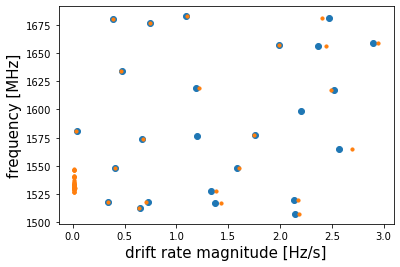

In [34]:
plt.scatter(np.abs(drifts), freqs)
plt.scatter(np.abs(found_drifts), found_freqs, s=10)
plt.xlabel('drift rate magnitude [Hz/s]', size=15)
plt.ylabel('frequency [MHz]', size=15)
plt.show()

In [29]:
# and finally we plot
import pandas as pd
event_df = pd.read_csv(csvf_path)
event_df = event_df.iloc[
    np.where(((event_df['Freq'].values > 1100) & (event_df['Freq'].values < 1200)) |
             ((event_df['Freq'].values > 1340) & (event_df['Freq'].values < 1900)))[0]]
event_df.dropna(subset=['in_n_ons'], inplace=True)
event_df.to_csv(f'/datax/scratch/benjb/C23_L_M31_injections/blc73_M31_found_event_table_3_trimmed.csv')
tcsvf_path = '/datax/scratch/benjb/C23_L_M31_injections/blc73_M31_found_event_table_3_trimmed.csv'


plot_event_pipeline: Opened file /datax/scratch/benjb/C23_L_M31_injections/blc73_M31_found_event_table_3_trimmed.csv
plot_event_pipeline: file = blc73_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.h5, tstart = 58832.18760416667, source_name = MESSIER031
plot_event_pipeline: file = blc73_guppi_58832_16530_HIP2792_0058.gpuspec.0000.h5, tstart = 58832.19131944444, source_name = HIP2792
plot_event_pipeline: file = blc73_guppi_58832_16851_MESSIER031_0059.gpuspec.0000.h5, tstart = 58832.19503472222, source_name = MESSIER031
plot_event_pipeline: file = blc73_guppi_58832_17168_HIP3077_0060.gpuspec.0000.h5, tstart = 58832.1987037037, source_name = HIP3077
plot_event_pipeline: file = blc73_guppi_58832_17485_MESSIER031_0061.gpuspec.0000.h5, tstart = 58832.202372685184, source_name = MESSIER031
plot_event_pipeline: file = blc73_guppi_58832_17801_HIP3223_0062.gpuspec.0000.h5, tstart = 58832.206030092595, source_name = HIP3223
Plotting some events for:  MESSIER031
There are 70 total events in the c

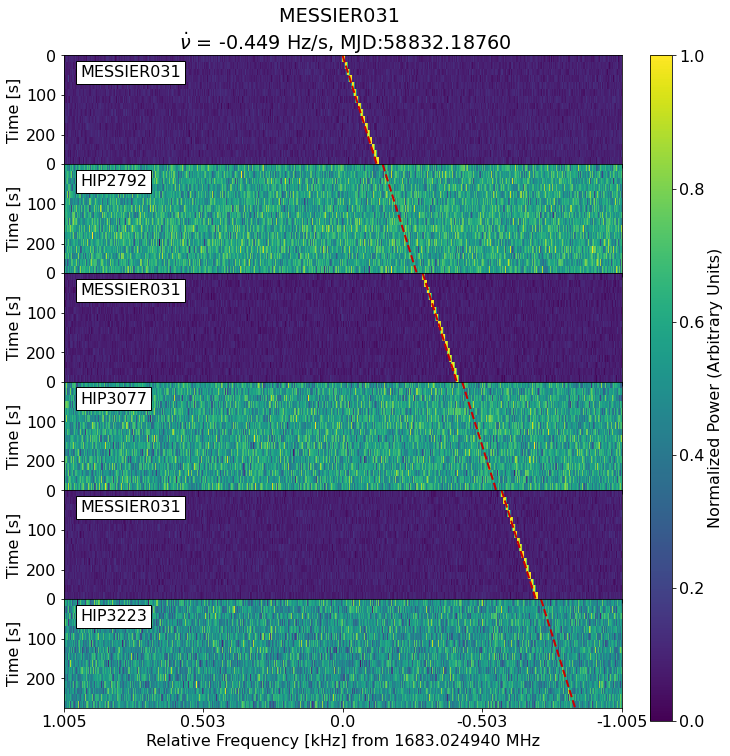

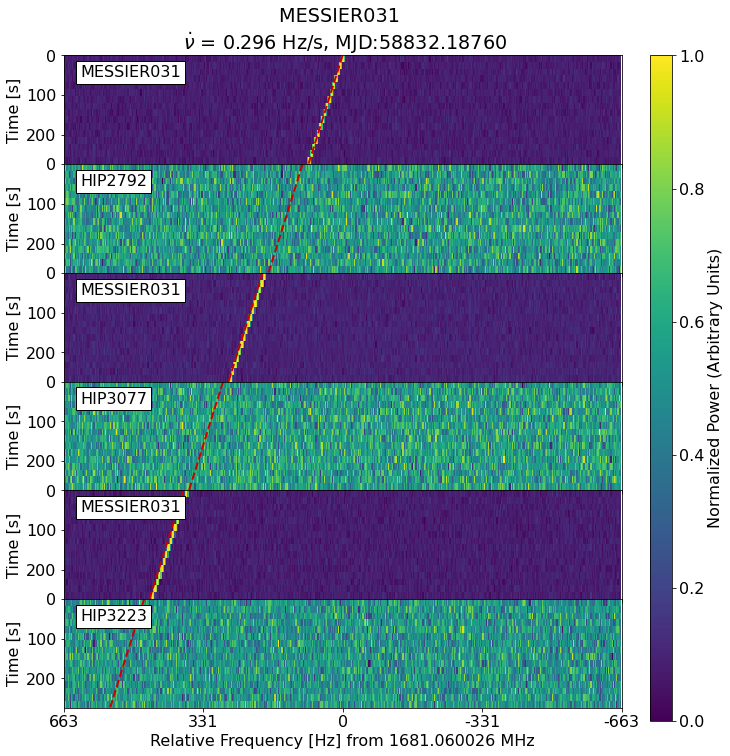

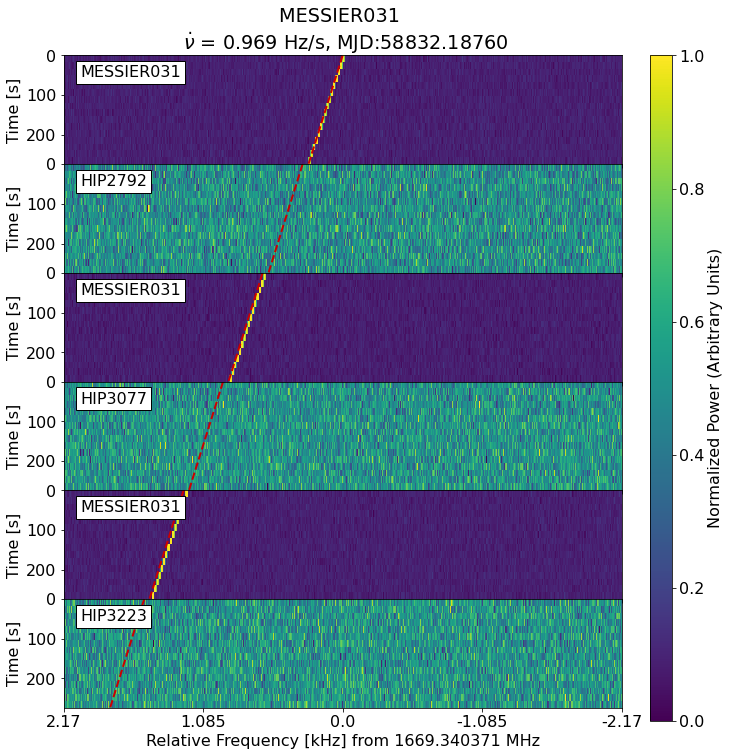

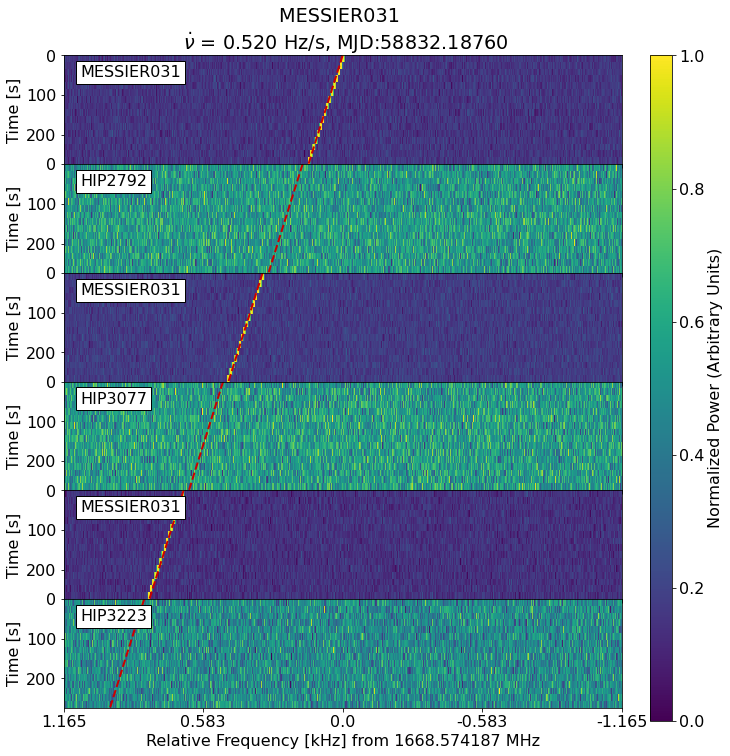

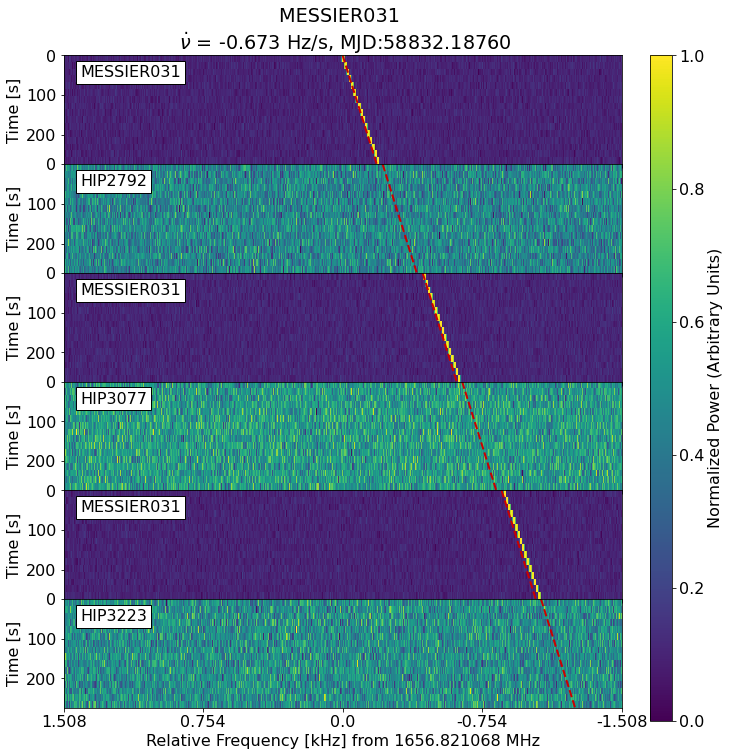

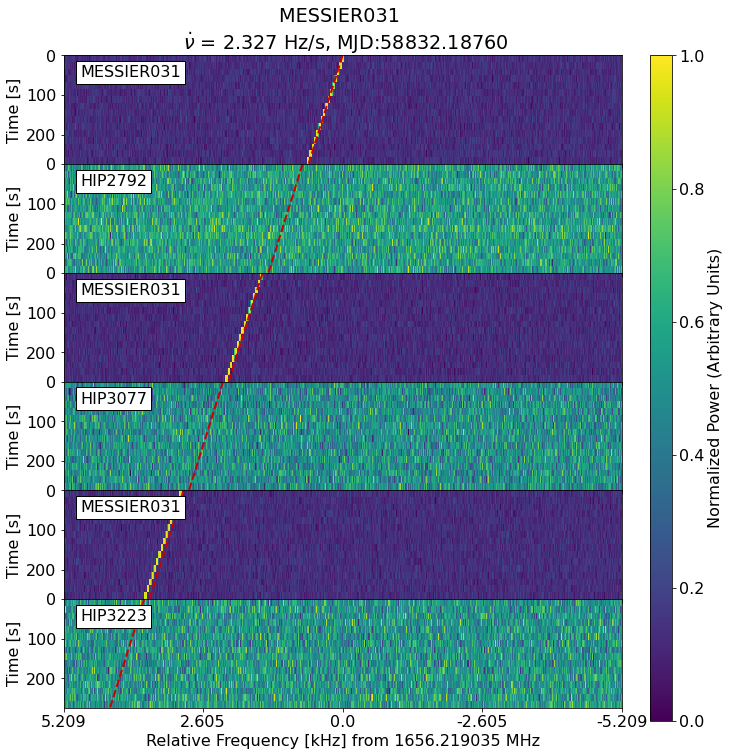

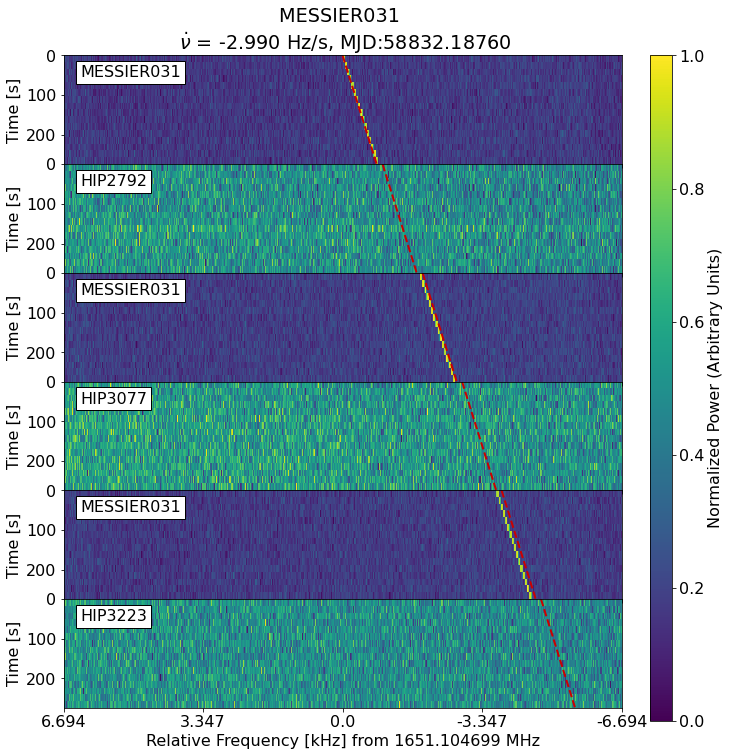

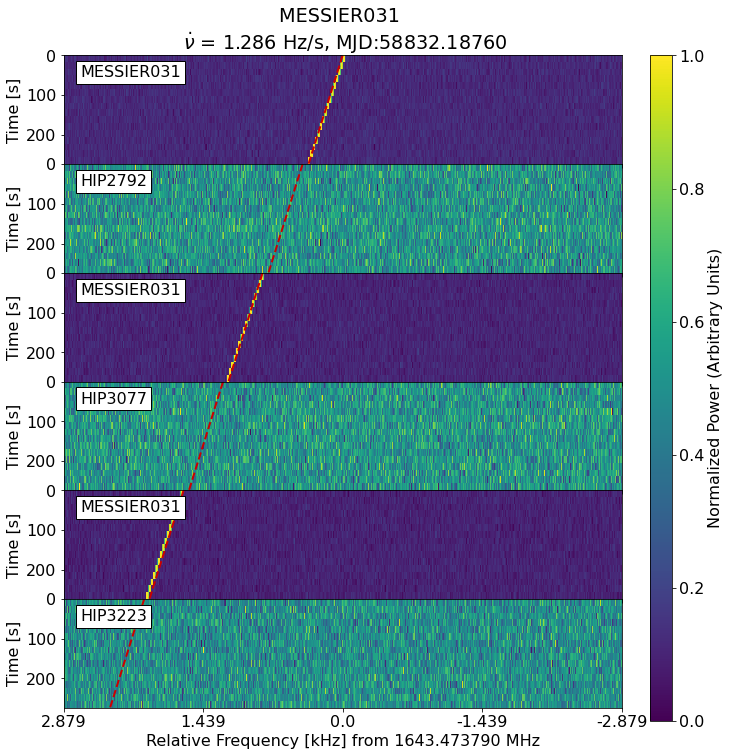

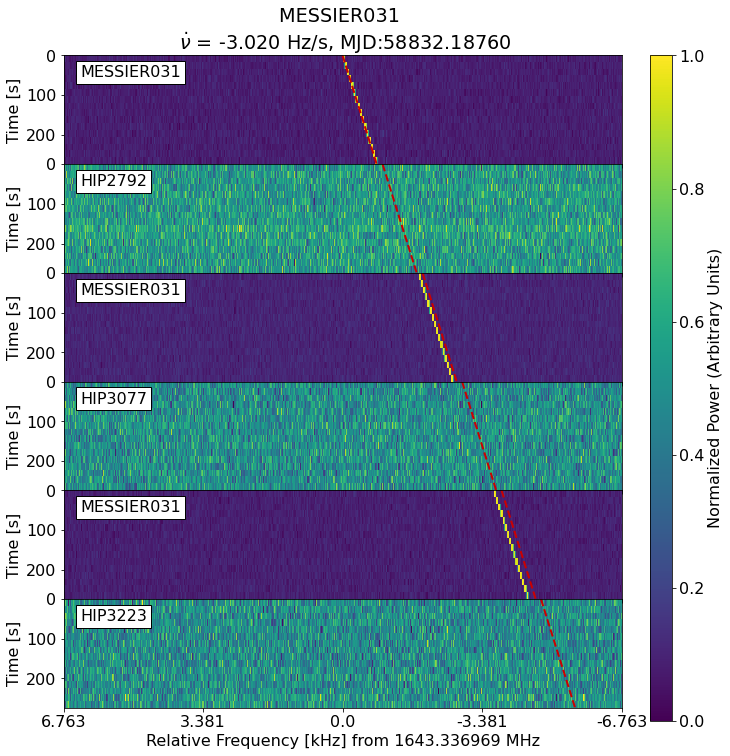

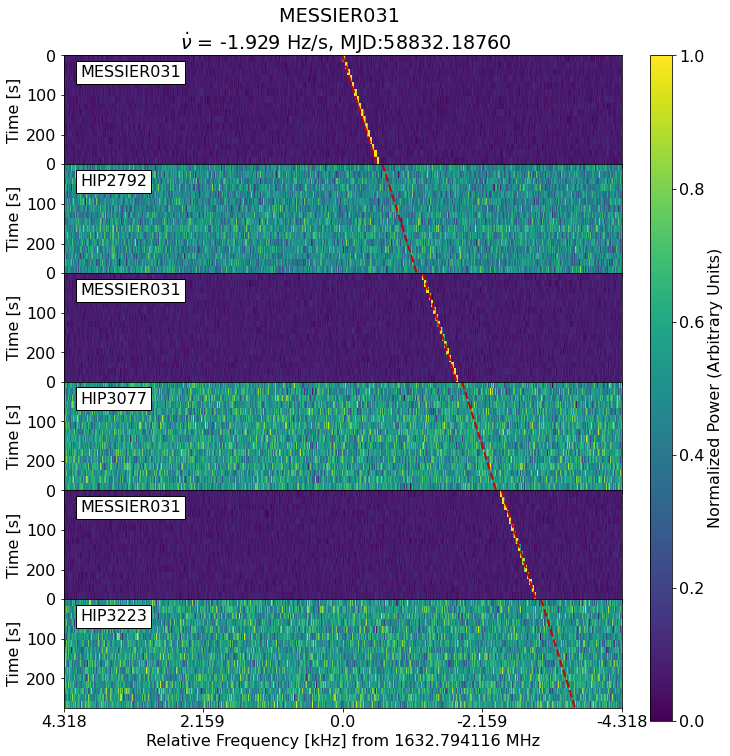

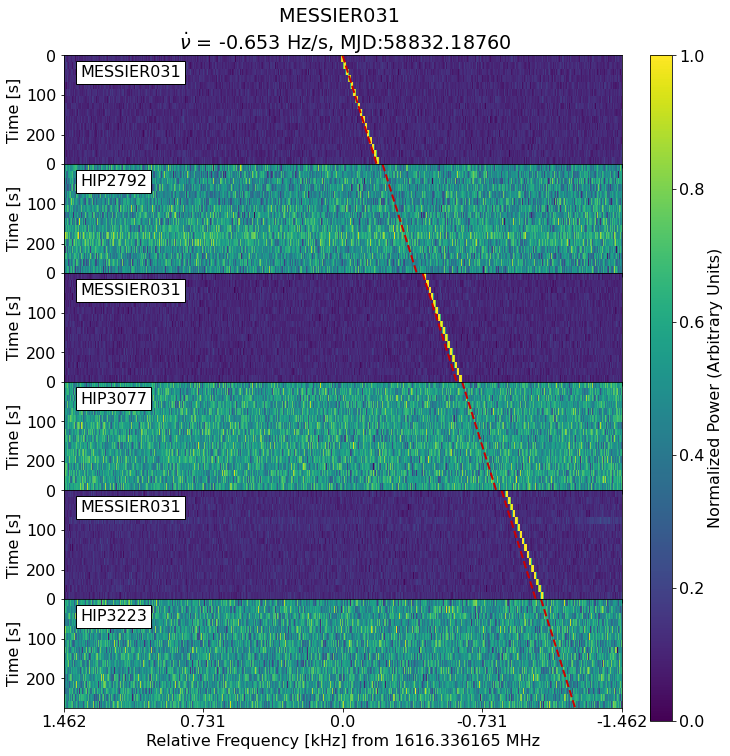

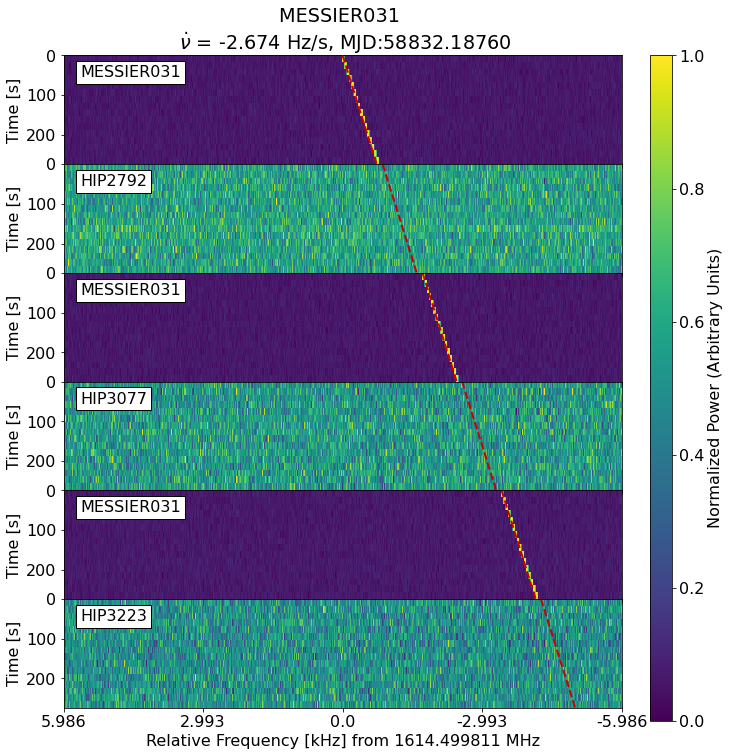

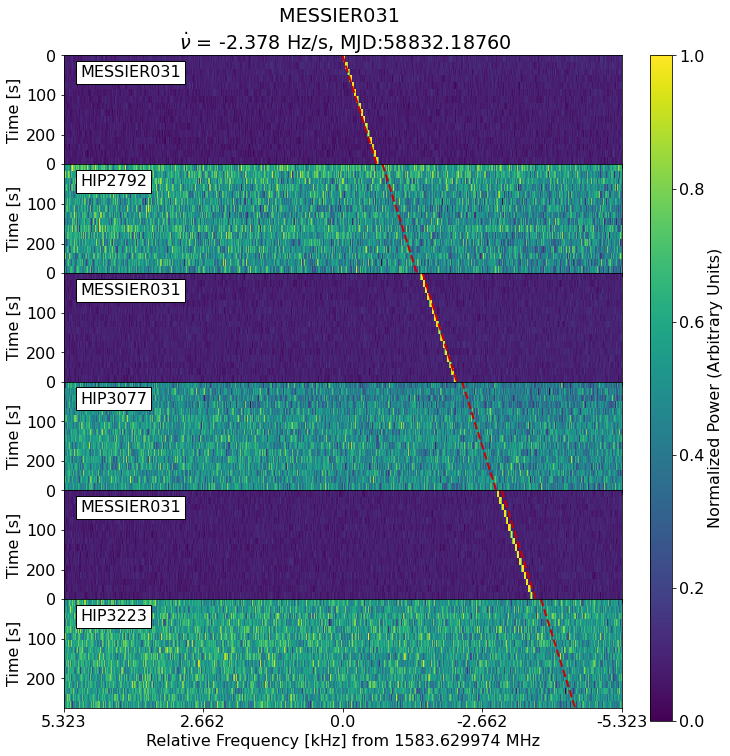

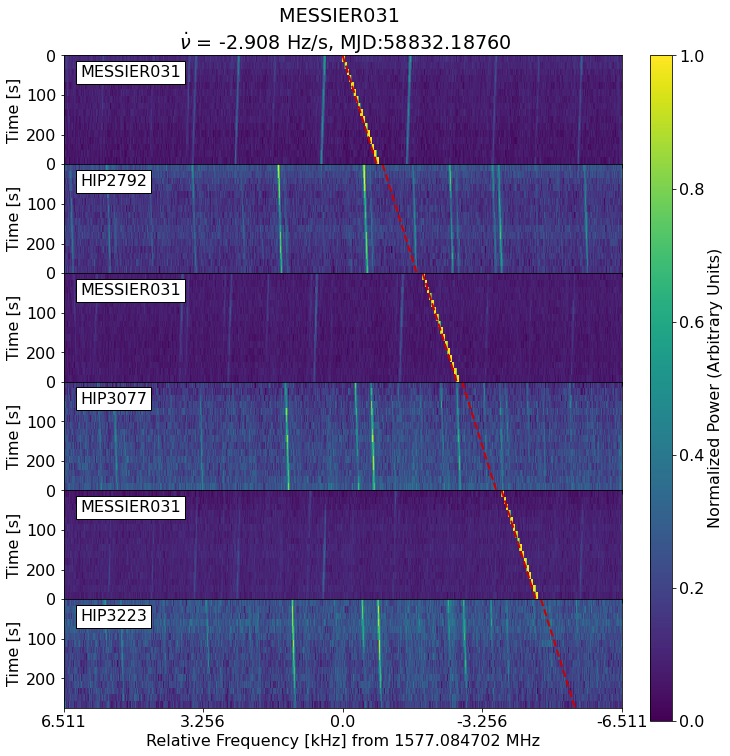

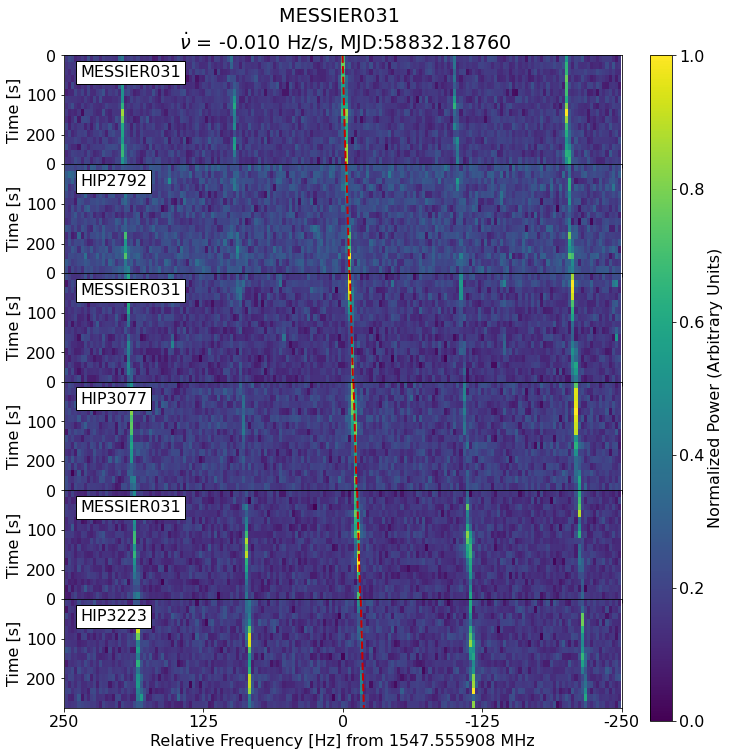

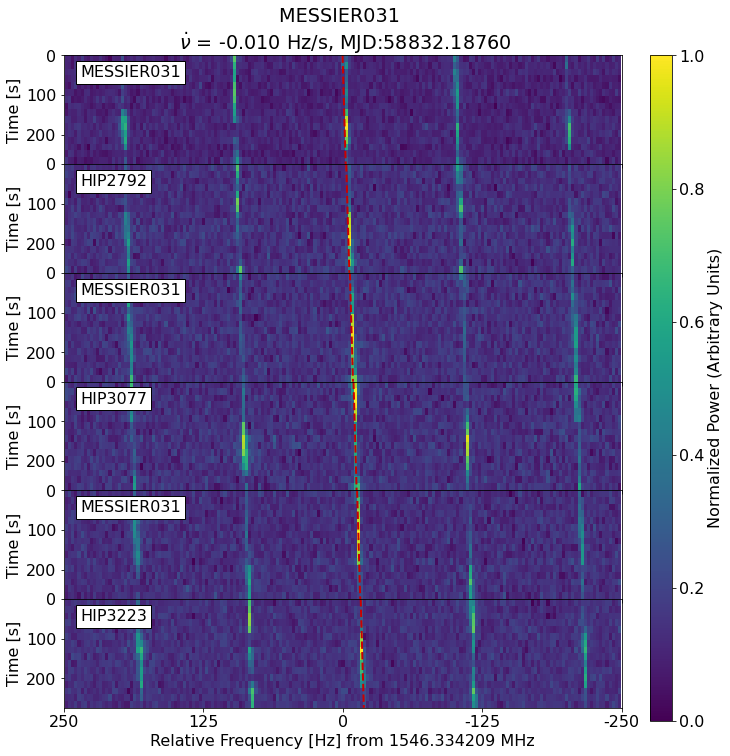

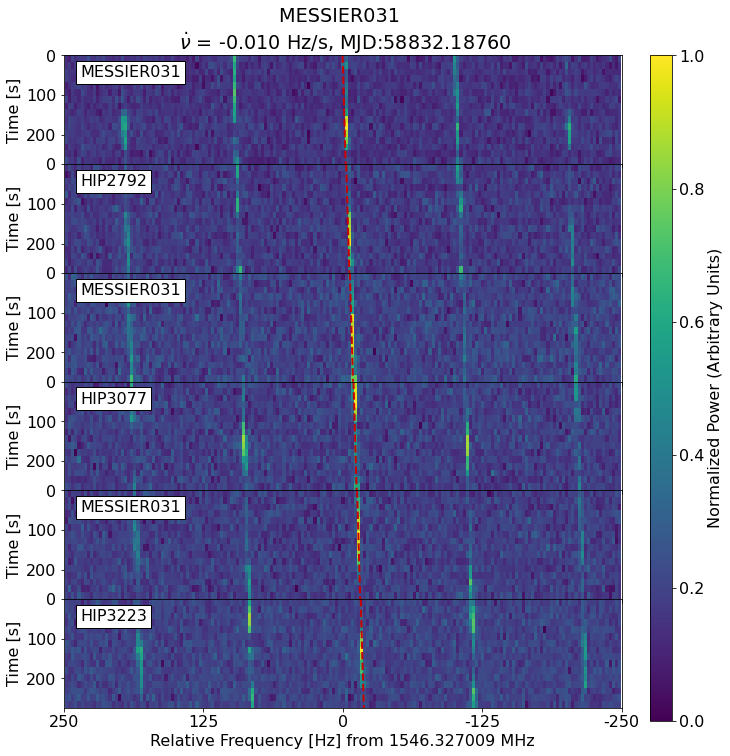

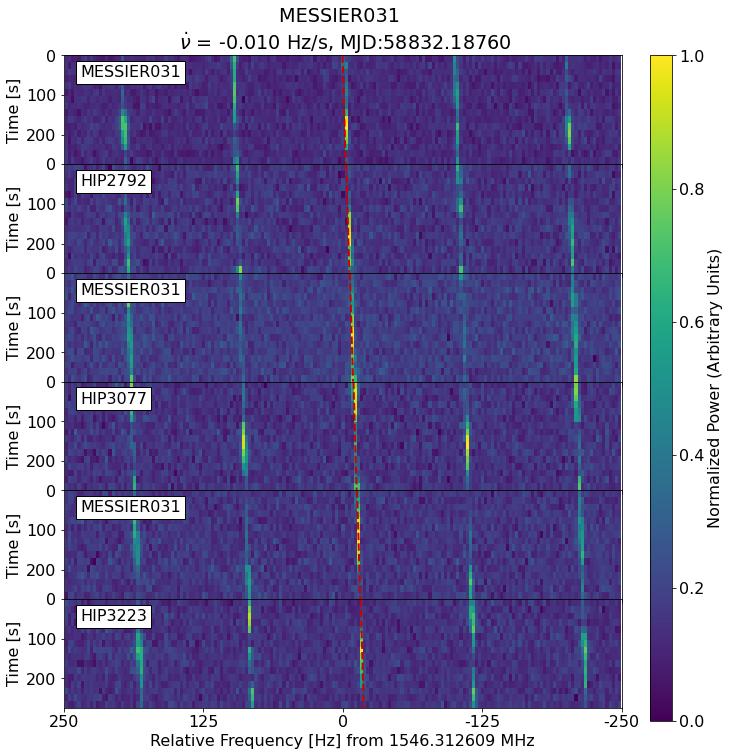

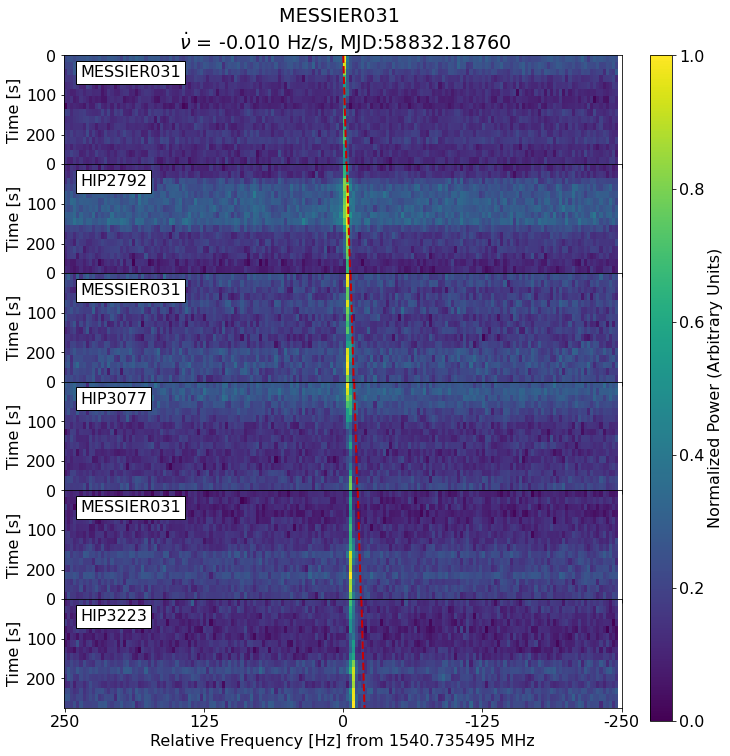

KeyboardInterrupt: 

In [68]:
plot_event_pipeline(tcsvf_path, # full path of the CSV file built by find_event_pipeline()
                    h5_list_path, # full path of text file containing the list of .h5 files
                    filter_spec='f{}'.format(3), # filter threshold
                    user_validation=False) # Non-interactive

In [10]:
import glob
print(glob.glob('/home/obs/turboseti/AGBT19B_999_121/blc71_blp01/blc71_guppi_*.gpuspec.0000/blc71_guppi_58832_09716_NGC7640_0037.gpuspec.0000.dat')[0])

/home/obs/turboseti/AGBT19B_999_121/blc71_blp01/blc71_guppi_58832_09716_NGC7640_0037.gpuspec.0000/blc71_guppi_58832_09716_NGC7640_0037.gpuspec.0000.dat
